# Loan Default Prediction

The purpose of this project is to use supervised learning principles to predict whether a loan will be defaulted based on several factors about the person taking the loan.

Defaulting a loan means the borrower failed to meet the obligations in the loan agreement, especially by failing to make payments on time. Banks and other institutions are very interested in predicting whether or not borrowers will default on a loan, because they want to maximize the amount of cash they earn back. In particular, they would also be very interested in predicting a percentage probability that a loan they provide will not default.

## Data source
The data used in this project is public, and was downloaded from [this Kaggle link](https://www.kaggle.com/datasets/nikhil1e9/loan-default). It contains information on over 255,000 different loans, along with information such as the age, income, and credit score of the borrower.

First, we import Python libraries and load the data from the .csv file.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./Loan_default.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


## Exploratory Data Analysis
### Preliminary Analysis

We find that this dataset has 255,347 rows and 18 columns including `Default`, which is the target variable. One of those columns, `LoanID`, is not useful for our purposes and therefore it is dropped immediately.

In [13]:
# Drop the LoanID column
df.drop('LoanID', axis="columns", inplace=True, errors='ignore')

We check whether there are any missing values or duplicated rows, and determine there are none.

In [14]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values) # No missing values

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


In [15]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Any duplicate rows? {duplicate_rows > 0}") # No duplicate rows

Any duplicate rows? False


For the columns with a small number of unique values, we check how many of each value there are to see how evenly they are distributed. We find that all of them are very close to evenly distributed, except for `Default`.

Afterwards, we plot a histogram of how likely a member of each category is to default, based on this data set.

In [16]:
# Check how many unique values are in each column
unique_values = df.nunique()
print(unique_values.sort_values())

HasCoSigner            2
HasMortgage            2
HasDependents          2
Default                2
MaritalStatus          3
NumCreditLines         4
EmploymentType         4
Education              4
LoanPurpose            5
LoanTerm               5
Age                   52
DTIRatio              81
MonthsEmployed       120
CreditScore          550
InterestRate        2301
Income            114620
LoanAmount        158729
dtype: int64


In [46]:
# Check the distribution of columns with few unique values
for column in df.columns:
    if df[column].nunique() <= 5:
        # print((df[column].value_counts() / len(df) * 100).round(1))
        pass
        
mean_default = df['Default'].mean()
print(f"Mean default rate: {mean_default}")

Mean default rate: 0.11612824901017048


We find that approximately 11.6% of all the loans were defaulted. Next, we compare the default rate of different types of borrowers, as compared to the mean.

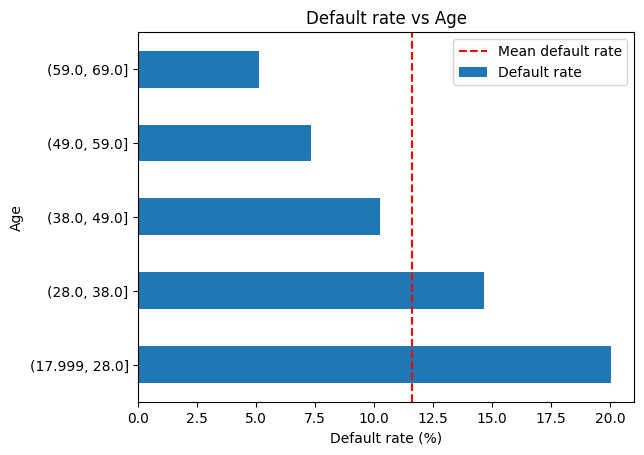

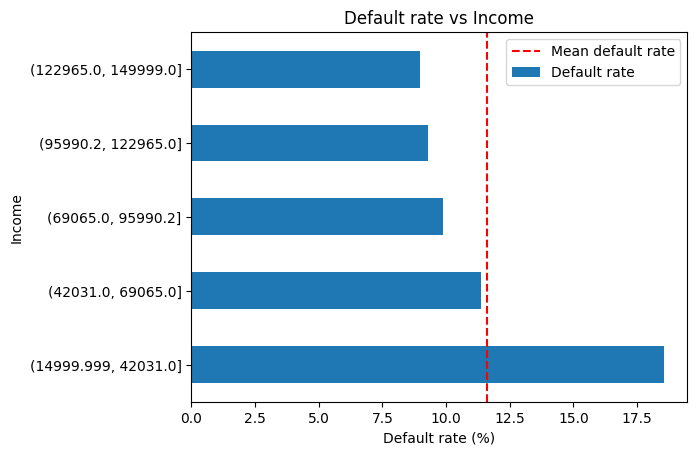

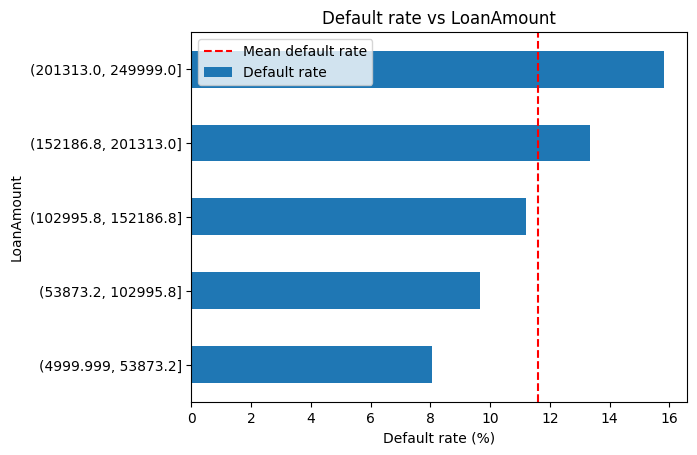

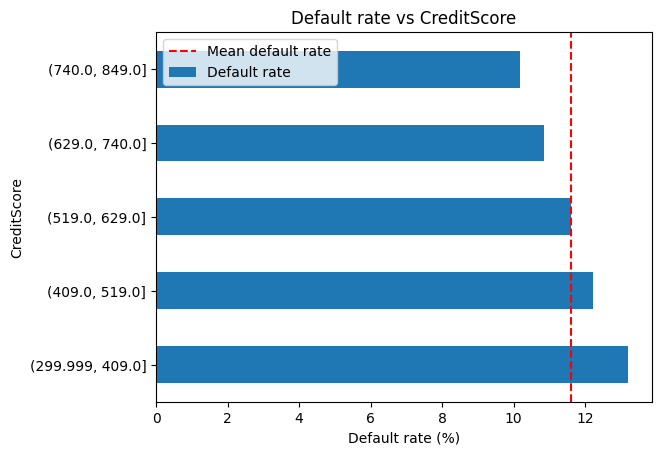

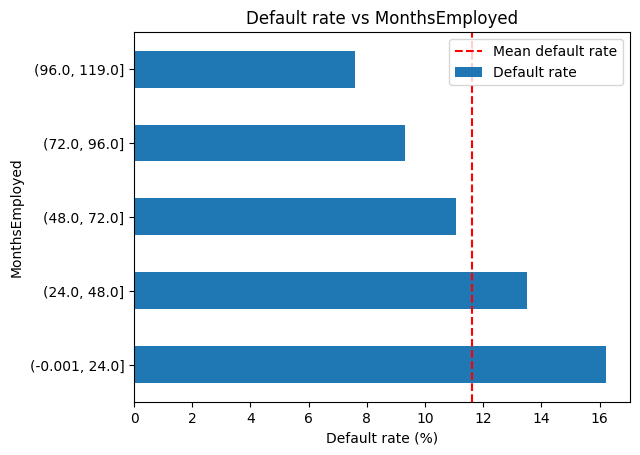

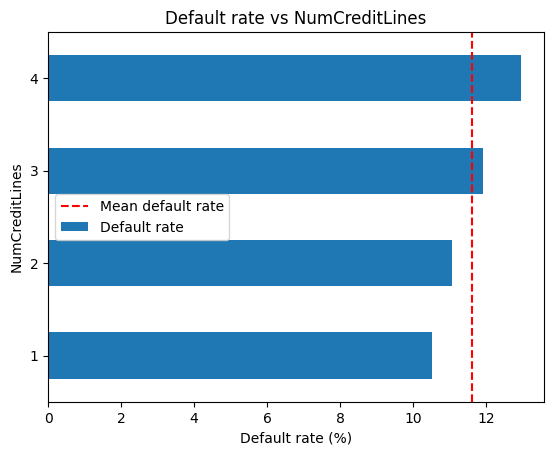

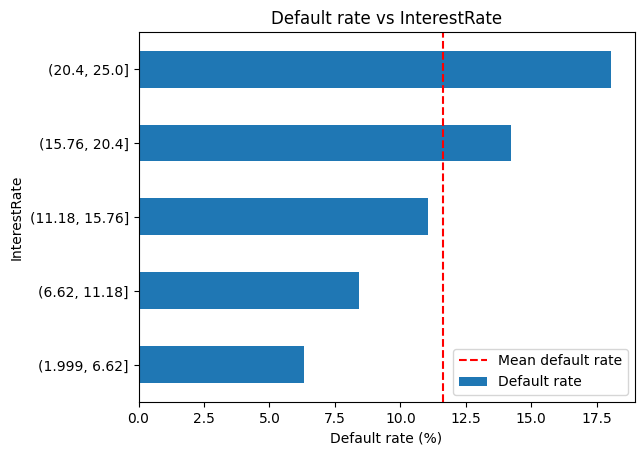

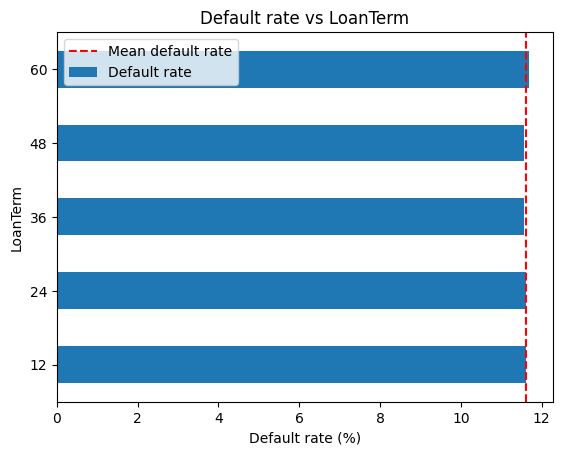

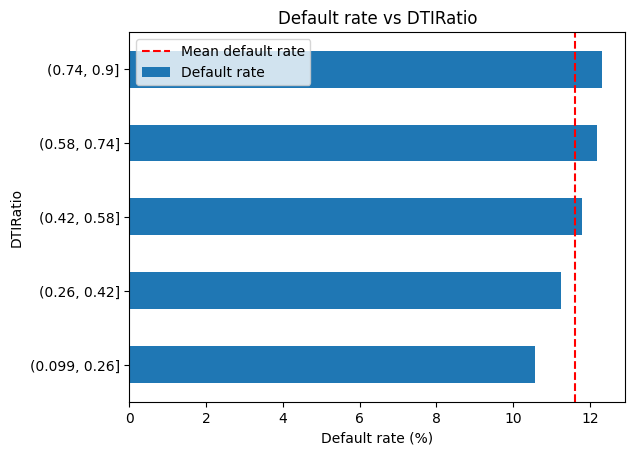

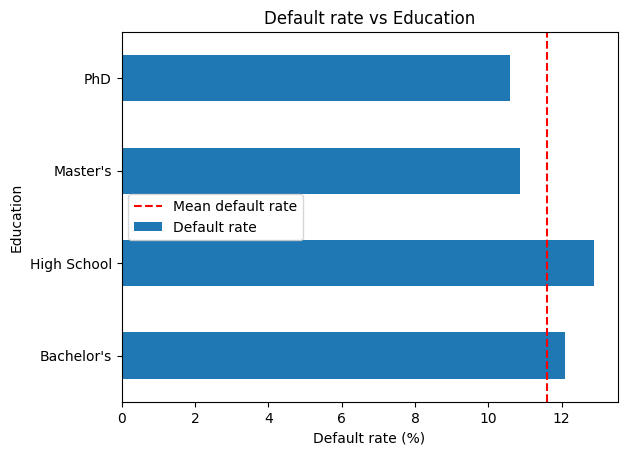

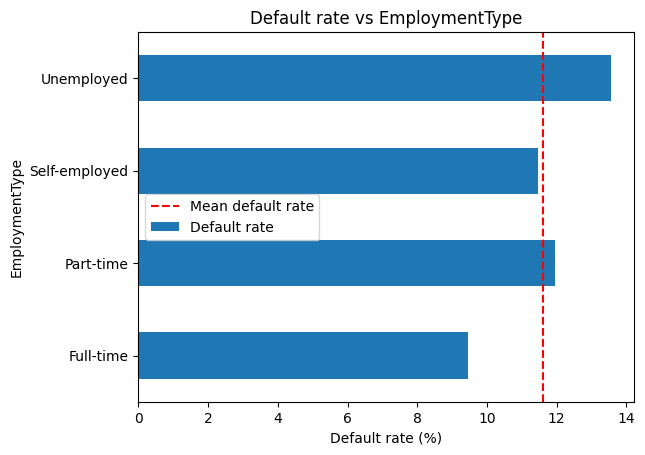

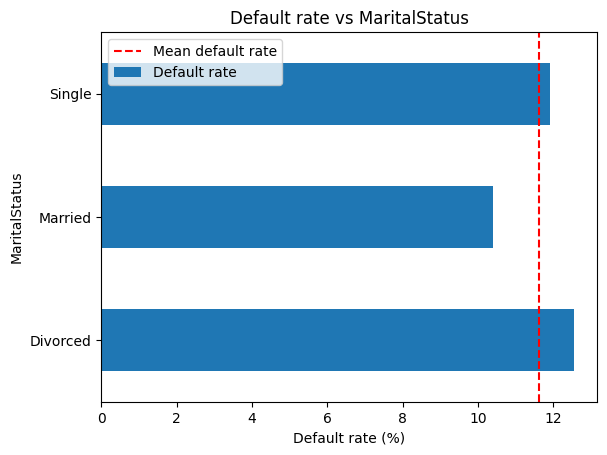

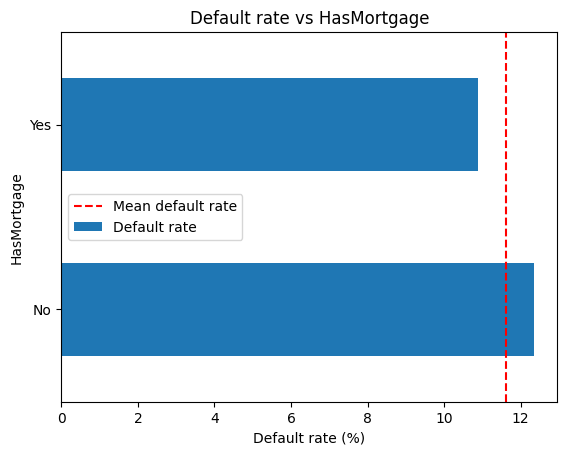

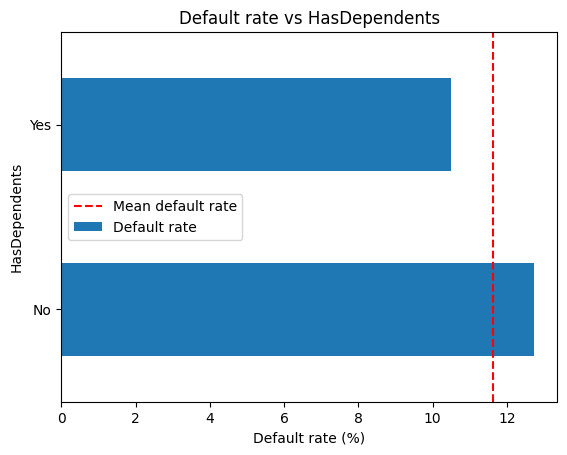

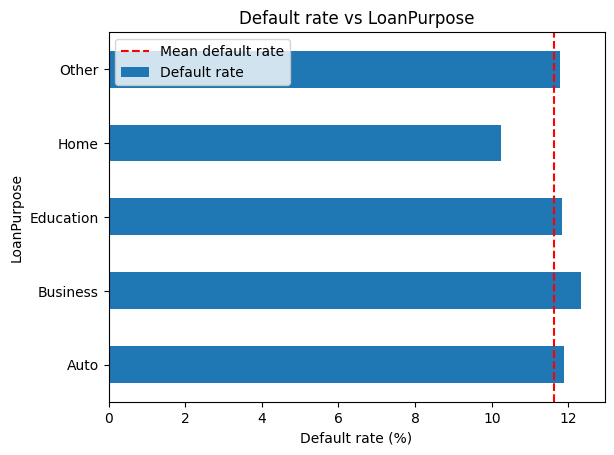

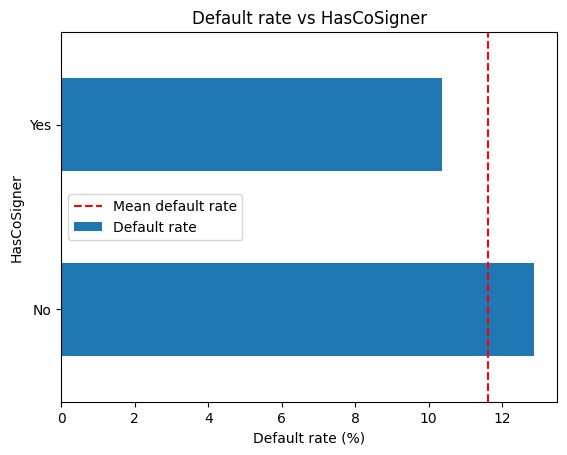

In [41]:
# Plot Default rates for columns
for column in df.columns:
    groups = pd.Series(dtype=float)  # Initialize groups as an empty Series
    if df[column].nunique() <= 5 and column != 'Default':
        # Few unique values
        groups = df.groupby(column)['Default'].mean().mul(100)
    elif column != 'Default' and np.issubdtype(df[column].dtype, np.number):
        # Many unique values, split into 5 groups
        groups = df.groupby(pd.qcut(df[column], 5))['Default'].mean().mul(100)
    
    if not groups.empty:
        groups.plot(kind='barh', title=f"Default rate vs {column}", xlabel='Default rate (%)')
        # Add the mean default rate
        plt.axvline(x=mean_default * 100, color='red', linestyle='--')
        plt.legend(['Mean default rate', 'Default rate'])
        plt.show()

We make the train and test sets, and encode the non-numeric columns as numbers so they can work with the classifiers. We also use SMOTE to handle the significant imbalance between defaulted and non-defaulted loans in our data set.

In [19]:
# Split the data into features and target

X = df.drop('Default', axis='columns')
y = df['Default']

# Encode categorical variables
le = LabelEncoder()
X_encoded = X.copy()
for column in X.columns:
    if X[column].dtype == 'object':
        X_encoded[column] = le.fit_transform(X[column])


# Use SMOTE to oversample the minority class
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

Next, we create a correlation matrix between the columns to determine whether there is any multicollinearity, and find that there is low correlation between the columns.

InterestRate      0.131273
LoanAmount        0.086659
NumCreditLines    0.028330
DTIRatio          0.019236
LoanTerm          0.000545
CreditScore      -0.034166
MonthsEmployed   -0.097374
Income           -0.099119
Age              -0.167783
dtype: float64


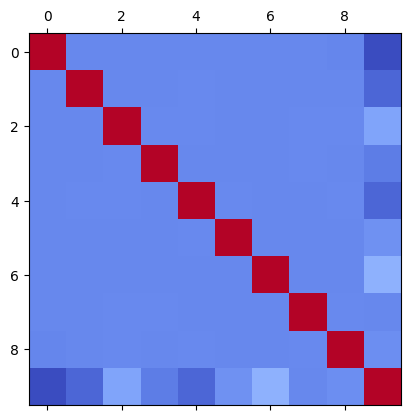

In [20]:
# Calculate correlation matrix for all numerical variables
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
# print(correlation_matrix)

# Plot the correlation matrix using a heatmap
plt.matshow(correlation_matrix, cmap='coolwarm')

# Find the correlation of all variables with the target variable
correlation_target = df_numeric.drop('Default', axis='columns').corrwith(df['Default'])
print(correlation_target.sort_values(ascending=False))

### 

### Data Cleaning Summary
We removed the `LoanID` column because it is irrelevant to our supervised learning model. We also encoded the non-numeric values as numeric so they can be used in our models.

We investigated the data in several other ways, and found nothing further to clean.

## Models


Two types of model we considered for this classification problem were **Logistic Regression** and **Trees**. Both of these can be suitable for classification tasks.

Between these, we decided to use Decision Trees for several reasons:
*  Its results are highly interpretable.
*  It is more suitable for large datasets with many different features including categorical ones.
*  It is unclear that there should be a linear relationship between the features and log odds, especially the categorical features.

Later, we will use random forests to reduce overfitting.

### Decision Tree Classifier
First, we consider using a Decision Tree classifier.

In [21]:
# Train a Decision Tree model
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") # Approx. 0.82
print(f"Precision: {precision}") # Approx. 0.80
print(f"Recall: {recall}") # Approx. 0.84
print(f"F1: {f1}") # Approx. 0.82

Accuracy: 0.8178736790801746
Precision: 0.8056685334639382
Recall: 0.837965936524108
F1: 0.8214999131492097


This model has metrics which seem good, but might be made better using an ensemble method such as random forest classifier.

### Random Forest Classifier

In [22]:
# Train a random forest classifier with the standard parameters
rf = RandomForestClassifier()
# Takes much longer to run, about 2 minutes on my machine.
rf.fit(X_train, y_train)

RandomForestClassifier()

After fitting our classifier, we check its accuracy by making predictions on the test set, and find which features are the most important.

Accuracy: 0.880236602494517
Precision: 0.8993185571086355
Recall: 0.85641514030697
F1: 0.8773426509960521


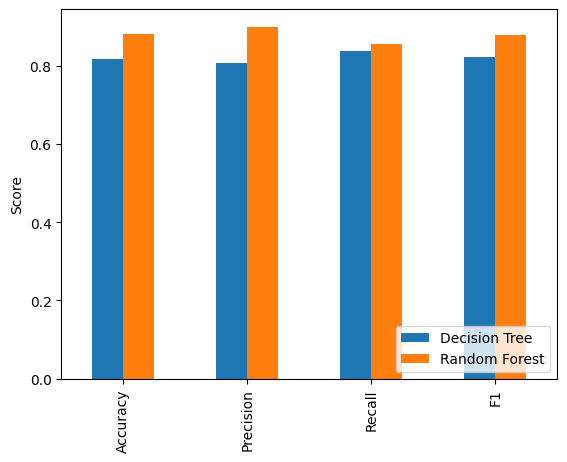

In [23]:
# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}") # Approx. 0.88
print(f"Precision: {precision_rf}") # Approx. 0.86
print(f"Recall: {recall_rf}") # Approx. 0.90
print(f"F1: {f1_rf}") # Approx. 0.88

# Plot the scores of the random forest model compared to the decision tree model
scores = {
    'Decision Tree': [accuracy, precision, recall, f1],
    'Random Forest': [accuracy_score(y_test, y_pred_rf), precision_score(y_test, y_pred_rf), recall_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf)]
}

df_scores = pd.DataFrame(scores, index=['Accuracy', 'Precision', 'Recall', 'F1'])
df_scores.plot(kind='bar')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()

Using random forest has improved the model in all listed metrics.


### Why SMOTE?

To clarify why it was necessary to use SMOTE to deal with the imbalance, we now train our model without using SMOTE.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)
rf_no_smote = RandomForestClassifier()
rf_no_smote.fit(X_train, y_train)

RandomForestClassifier()

Accuracy: 0.885823379674956
Recall: 0.05011812352345596
Precision: 0.5951903807615231
F1: 0.09245136186770428


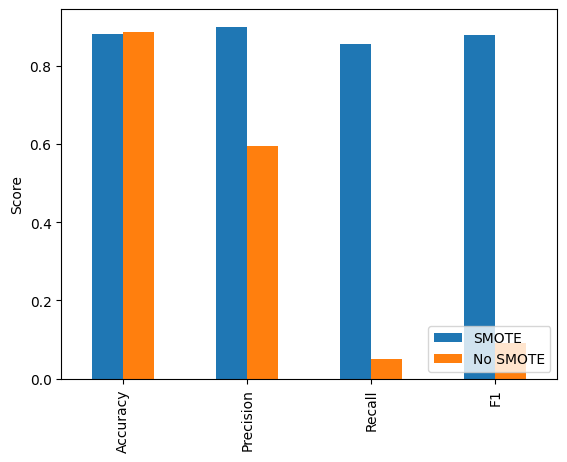

In [25]:
y_pred_no_smote = rf_no_smote.predict(X_test)
accuracy_no_smote = accuracy_score(y_test, y_pred_no_smote)
precision_no_smote = precision_score(y_test, y_pred_no_smote)
recall_no_smote = recall_score(y_test, y_pred_no_smote)
f1_no_smote = f1_score(y_test, y_pred_no_smote)
print(f"Accuracy: {accuracy_no_smote}") # Approx. 0.88
print(f"Recall: {recall_no_smote}") # Approx. 0.04
print(f"Precision: {precision_no_smote}") # Approx. 0.58
print(f"F1: {f1_no_smote}") # Approx. 0.09

# Plot the scores of the random forest model compared to the decision tree model
scores = {
    'SMOTE': [accuracy_rf, precision_rf, recall_rf, f1_rf],
    'No SMOTE': [accuracy_no_smote, precision_no_smote, recall_no_smote, f1_no_smote]
}

df_scores = pd.DataFrame(scores, index=['Accuracy', 'Precision', 'Recall', 'F1'])
df_scores.plot(kind='bar')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()

Without using SMOTE, the precision and recall are extremely poor, making this model a very bad selection.

## Conclusion
We have built and fit a random forest classifier to extrapolate whether or not a borrower will default on their loans based on several features such as income and age. The most important metric for this problem is recall because giving a loan to a borrower who defaults is a greater cost than not giving a loan to someone who would not have defaulted. The classifier we developed has a high recall of roughly 86%, but is also fairly high in precision.

The data set was highly imbalanced, and if the classifier was run without oversampling the minority cases, it would be extremely ineffective. This problem was overcome by using SMOTE to oversample and interpolate the minority cases.

This classifier used the default hyperparameters in `RandomForestClassifier`. It is possible that using `GridSearchCV` or `RandomizedSearchCV` to test different hyperparameters might improve the classifier even more.

## Github Repo
This notebook is available on Github at https://github.com/maxzhu213/CSCA-5622-Project